In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d datamunge/sign-language-mnist
!unzip ./sign-language-mnist.zip

 97% 61.0M/62.6M [00:00<00:00, 127MB/s]
100% 62.6M/62.6M [00:00<00:00, 116MB/s]
Archive:  ./sign-language-mnist.zip
  inflating: amer_sign2.png          
  inflating: amer_sign3.png          
  inflating: american_sign_language.PNG  
  inflating: sign_mnist_test.csv     
  inflating: sign_mnist_test/sign_mnist_test.csv  
  inflating: sign_mnist_train.csv    
  inflating: sign_mnist_train/sign_mnist_train.csv  


In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import seaborn as sns
plt.rcParams['font.size'] = 12
plt.rcParams['lines.color'] ='#000000'
np.random.seed(42)

In [4]:
train_path = './sign_mnist_train/sign_mnist_train.csv'
test_path = './sign_mnist_test/sign_mnist_test.csv'

In [6]:
train = pd.read_csv(train_path) # import training data
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


In [7]:
test = pd.read_csv(test_path) # import test set
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,152,152,152,152,152,153,153,151,152,152,153,152,152,151,151,150,150,150,149,150,150,150,152,152,151,152,152,152,152,152,...,131,134,144,147,125,87,87,103,107,110,116,113,75,74,74,74,76,74,82,134,168,155,146,137,145,146,149,135,124,125,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,138,137,137,138,138,139,137,142,140,138,139,137,137,136,135,134,133,134,132,129,132,134,135,135,137,139,139,139,140,141,...,114,112,89,48,133,194,182,185,184,184,182,181,172,174,177,178,178,179,181,183,187,175,165,154,118,107,100,75,96,83,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,152,157,163,168,171,182,172,175,185,183,184,185,185,185,183,183,182,181,178,86,88,93,96,108,125,137,145,149,154,160,...,145,123,78,162,239,227,229,226,226,225,224,222,89,91,94,111,136,154,167,184,125,3,166,225,195,188,172,185,161,122,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,209,208,207,207,209,208,210,210,207,209,209,208,209,210,209,207,208,209,207,206,208,209,208,208,210,211,210,211,209,209,...,85,80,84,151,238,255,255,250,237,245,250,232,103,101,102,103,95,208,231,227,209,190,179,182,152,150,159,119,83,63,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,203,204,204,204,203,202,198,216,217,135,181,200,195,194,193,190,189,187,185,190,194,196,197,200,202,204,206,207,207,206,...,93,52,24,53,63,33,41,51,48,45,49,55,149,150,150,148,147,151,124,82,84,81,69,81,111,103,84,75,53,28,26,40,64,48,29,46,49,46,46,53


In [8]:
print('shape of training data:', train.shape) # (nrow, ncolumn)
print('shape of testing data:', test.shape) # (nrow, ncolumn)

''' na count over all rows and columns
first sum = sums over rows, last sum = sums over columns
'''
print('na count train:', train.isna().sum().sum())
print('na count test:', test.isna().sum().sum())

shape of training data: (27455, 785)
shape of testing data: (7172, 785)
na count train: 0
na count test: 0


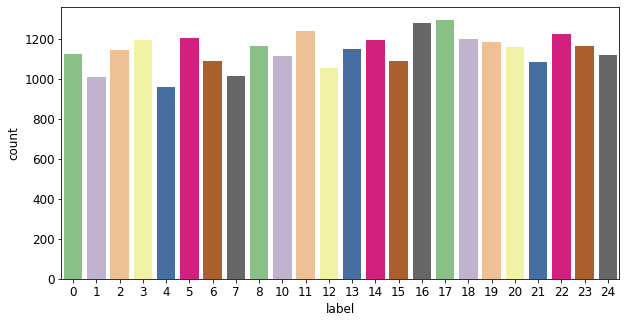

In [27]:
fig = plt.figure(figsize=(10,5))
ax = sns.countplot(x=train['label'], palette='Accent') # plot train label distribution
plt.show()

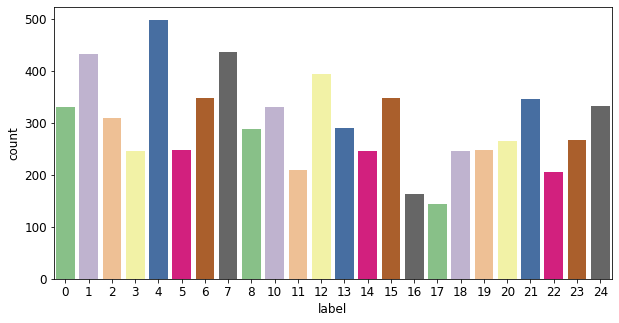

In [29]:
fig = plt.figure(figsize=(10,5))
ax = sns.countplot(x=test['label'], palette='Accent') # plot test label distribution
plt.show()

we could notice that there are no example in both train set and test set with label 9

In [159]:
X = train.drop('label', axis=1) # features
y = keras.utils.to_categorical(train['label']) # encode target

X_test = test.drop('label', axis=1)
y_test = keras.utils.to_categorical(test['label'])

In [160]:
# reshape square black and white images
def reshape_bw(X):
    samples, width, channel = X.shape[0], int(X.shape[1] ** (1/2)) , 1
    return X.values.reshape(samples, width, width, channel)  

In [161]:
X = reshape_bw(X)
X_test = reshape_bw(X_test)
width, height, channel = X.shape[1], X.shape[2], X.shape[3]

label: 3


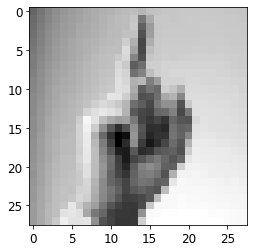

label: 6


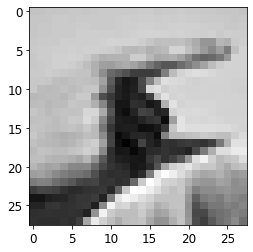

In [163]:
# plot a square black and white image
def plot_image(X, width):
    _ = plt.imshow(X.reshape(width, width), cmap='gray')
    plt.show()

# plot sample image
print('label:', y[0].argmax())    
plot_image(X[0], width)
print('label:', y_test[0].argmax())    
plot_image(X_test[0], width)

In [164]:
# split data into train and validation set with same target distribution as before spliting
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [165]:
# create data augmentor and fit it on train set
generator = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True, # make pixel intensity mean = 0 pixel-wise
    featurewise_std_normalization=True, # make pixel intensity s.d. = 1 pixel-wise
    height_shift_range=0.15, # shift image vertically (up or down) by 0.15 * 28 pixel
    width_shift_range=0.15, # shift image horizontally (left or right) by 0.15 * 28 pixel
    fill_mode='nearest'
)
generator.fit(X_train)

In [178]:
# build neural network as finalized by performance on test set
def build_model(func, init):
    keras.backend.clear_session()
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(64, (5, 5), padding="same", kernel_initializer=init(), input_shape=X_train.shape[1:]))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation(func))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(128, (5, 5), padding="same", kernel_initializer=init()))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation(func))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(256, (5, 5), padding="same", kernel_initializer=init()))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation(func))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(y.shape[1], activation='softmax', kernel_initializer=init()))
    return model

In [202]:
# use elu activation as an alternative to avoid dead relu problem
model_elu = build_model(keras.activations.elu, keras.initializers.glorot_uniform)
# compile model
model_elu.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.005),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(name='auc')]
)

In [203]:
# deine callbacks, use AUC to minimize missclassification
cb_elu = [keras.callbacks.ModelCheckpoint('model_elu_base.h5', monitor='val_auc', mode='max',save_best_only=True), 
          keras.callbacks.ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.3, patience=2, min_lr=0.00001)]

In [204]:
history_elu = model_elu.fit(generator.flow(X_train, y_train, batch_size=32), \
                    epochs=20, \
                    validation_data=generator.flow(X_val, y_val, batch_size=32), \
                    callbacks=cb_elu,
                    verbose=2)

Epoch 1/20
687/687 - 18s - loss: 1.2513 - accuracy: 0.6840 - precision: 0.7945 - recall: 0.6334 - auc: 0.9531 - val_loss: 0.2464 - val_accuracy: 0.9170 - val_precision: 0.9296 - val_recall: 0.9048 - val_auc: 0.9962
Epoch 2/20
687/687 - 16s - loss: 0.1329 - accuracy: 0.9570 - precision: 0.9636 - recall: 0.9521 - auc: 0.9984 - val_loss: 0.1536 - val_accuracy: 0.9497 - val_precision: 0.9551 - val_recall: 0.9461 - val_auc: 0.9973
Epoch 3/20
687/687 - 16s - loss: 0.0773 - accuracy: 0.9761 - precision: 0.9780 - recall: 0.9738 - auc: 0.9989 - val_loss: 0.1070 - val_accuracy: 0.9687 - val_precision: 0.9706 - val_recall: 0.9678 - val_auc: 0.9980
Epoch 4/20
687/687 - 16s - loss: 0.0890 - accuracy: 0.9738 - precision: 0.9759 - recall: 0.9724 - auc: 0.9981 - val_loss: 0.0440 - val_accuracy: 0.9849 - val_precision: 0.9858 - val_recall: 0.9842 - val_auc: 0.9990
Epoch 5/20
687/687 - 16s - loss: 0.0748 - accuracy: 0.9781 - precision: 0.9796 - recall: 0.9772 - auc: 0.9983 - val_loss: 0.1362 - val_accur

In [205]:
def plot_learning_curve(history):
    ephs = np.arange(0, len(history.history['loss'])) + 1
    fig = plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot(ephs, history.history['accuracy'], '--')
    plt.plot(ephs, history.history['val_accuracy'], '--')
    plt.legend(['accuracy', 'val_accuracy'])
    plt.subplot(1,2,2)
    plt.plot(ephs, history.history['loss'], '--')
    plt.plot(ephs, history.history['val_loss'], '--')
    plt.legend(['loss', 'val_loss'])
    plt.show()

learning curve of glorot uniform model


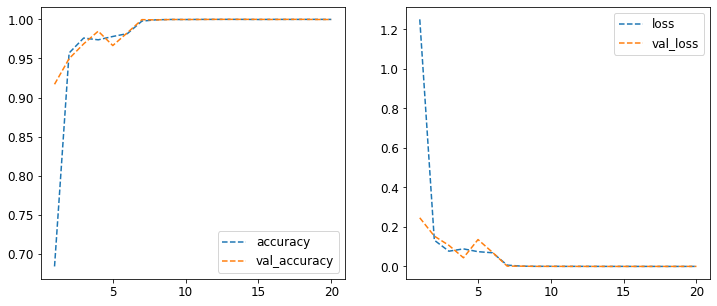

In [206]:
print(f"learning curve of glorot uniform model")
plot_learning_curve(history_elu)

from the learning curve, model converge after 5 th epoch

In [207]:
def evaluate(model):
    loss, acc, pre, rec, auc = model.evaluate(generator.flow(X_test, y_test, batch_size=32))
    print()
    print(f"test loss: {loss}")
    print(f"test accuracy: {round(acc*100,2)} %")
    print(f"test precision: {pre}")
    print(f"test recall: {rec}")
    print(f"test AUC: {auc}")
    print()
    index = int(input("Enter image index: ")) % X_test.shape[0]
    print(f"label: {np.argmax(model.predict(np.expand_dims([X_test[index]], axis=-1), verbose=0))}")
    print(f"actual label: {y_test[index].argmax()}")
    plot_image(X_test[index], width)

225/225 [==============================] - 4s 19ms/step - loss: 0.0221 - accuracy: 0.9943 - precision: 0.9947 - recall: 0.9941 - auc: 0.9993

test loss: 0.022074230015277863
test accuracy: 99.43 %
test precision: 0.9946986436843872
test recall: 0.9941439032554626
test AUC: 0.9992859959602356

Enter image index: 467298
label: 3
actual label: 3


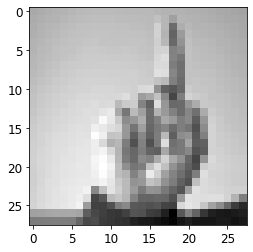

In [208]:
evaluate(model_elu)

In [209]:
from sklearn.metrics import confusion_matrix
def plot_confmat(model):   
    cm = confusion_matrix(test['label'], model.predict(X_test).argmax(-1))
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, cmap=plt.cm.Purples)
    plt.ylabel('actual')
    plt.xlabel('predicted')
    plt.show()

confusion matrix of glorot uniform model


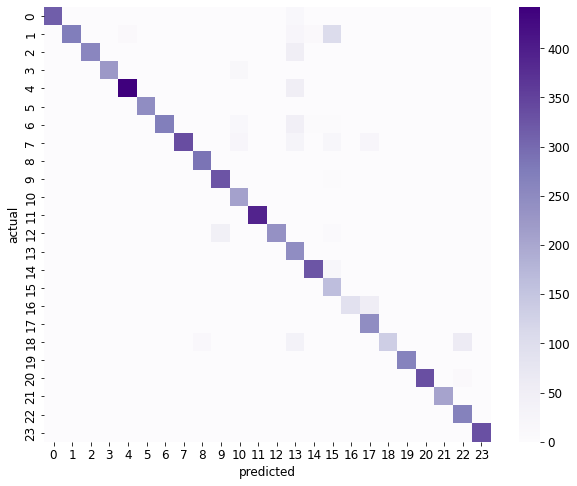

In [213]:
print(f"confusion matrix of glorot uniform model")
plot_confmat(model_elu)

In [212]:
from sklearn.metrics import classification_report
def print_report(model):
  print(classification_report(test['label'],  model.predict(X_test).argmax(-1)))

In [227]:
print("classification report of glorot uniform model")
print_report(model_elu)

classification report of glorot uniform model
              precision    recall  f1-score   support

           0       1.00      0.95      0.98       331
           1       1.00      0.63      0.77       432
           2       1.00      0.83      0.91       310
           3       1.00      0.92      0.96       245
           4       0.97      0.89      0.93       498
           5       1.00      1.00      1.00       247
           6       1.00      0.78      0.88       348
           7       1.00      0.77      0.87       436
           8       0.95      1.00      0.97       288
          10       0.87      0.99      0.92       331
          11       0.78      1.00      0.88       209
          12       1.00      0.99      1.00       394
          13       1.00      0.81      0.90       291
          14       0.48      1.00      0.65       246
          15       0.95      0.94      0.94       347
          16       0.49      1.00      0.65       164
          17       1.00      0.62  

In [219]:
# same architecture but different initializer
model_elu_2 = build_model(keras.activations.elu, keras.initializers.he_uniform)
# compile model
model_elu_2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.005),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(name='auc')]
)

In [220]:
cb_elu_2 = [keras.callbacks.ModelCheckpoint('model_elu2_base.h5', monitor='val_auc', mode='max',save_best_only=True), 
          keras.callbacks.ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.3, patience=2, min_lr=0.00001)]

In [222]:
history_elu_2 = model_elu_2.fit(generator.flow(X_train, y_train, batch_size=32), \
                    epochs=20, \
                    validation_data=generator.flow(X_val,y_val,batch_size=32), \
                    callbacks=cb_elu_2,
                    verbose=2)

Epoch 1/20
687/687 - 16s - loss: 0.5074 - accuracy: 0.8428 - precision: 0.8872 - recall: 0.8135 - auc: 0.9893 - val_loss: 0.2000 - val_accuracy: 0.9326 - val_precision: 0.9409 - val_recall: 0.9270 - val_auc: 0.9967
Epoch 2/20
687/687 - 16s - loss: 0.0947 - accuracy: 0.9706 - precision: 0.9745 - recall: 0.9677 - auc: 0.9987 - val_loss: 0.0600 - val_accuracy: 0.9805 - val_precision: 0.9825 - val_recall: 0.9791 - val_auc: 0.9993
Epoch 3/20
687/687 - 16s - loss: 0.0731 - accuracy: 0.9775 - precision: 0.9794 - recall: 0.9761 - auc: 0.9988 - val_loss: 0.1629 - val_accuracy: 0.9536 - val_precision: 0.9568 - val_recall: 0.9510 - val_auc: 0.9959
Epoch 4/20
687/687 - 16s - loss: 0.0841 - accuracy: 0.9777 - precision: 0.9791 - recall: 0.9768 - auc: 0.9977 - val_loss: 0.0364 - val_accuracy: 0.9896 - val_precision: 0.9900 - val_recall: 0.9891 - val_auc: 0.9993
Epoch 5/20
687/687 - 16s - loss: 0.0061 - accuracy: 0.9981 - precision: 0.9983 - recall: 0.9980 - auc: 1.0000 - val_loss: 0.0029 - val_accur

learning curve of he uniform model


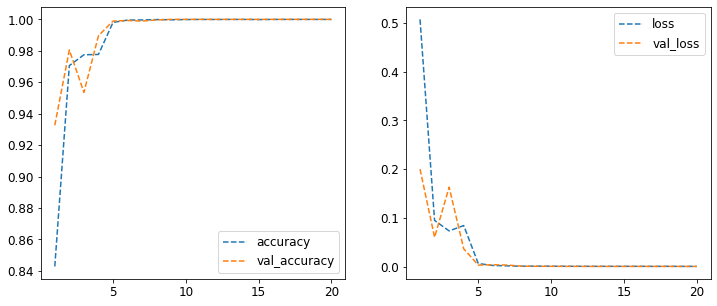

In [226]:
print(f"learning curve of he uniform model")
plot_learning_curve(history_elu_2)

model took shorter to converge than the one with glorot uniform

225/225 [==============================] - 4s 19ms/step - loss: 0.0091 - accuracy: 0.9971 - precision: 0.9973 - recall: 0.9965 - auc: 1.0000

test loss: 0.00912280660122633
test accuracy: 99.71 %
test precision: 0.9973486065864563
test recall: 0.9965142011642456
test AUC: 0.9999982714653015

Enter image index: 1162398
label: 14
actual label: 14


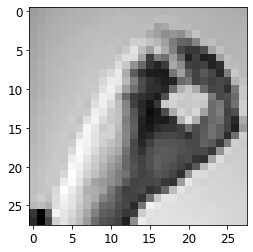

In [224]:
evaluate(model_elu_2)

confusion matrix of he uniform model


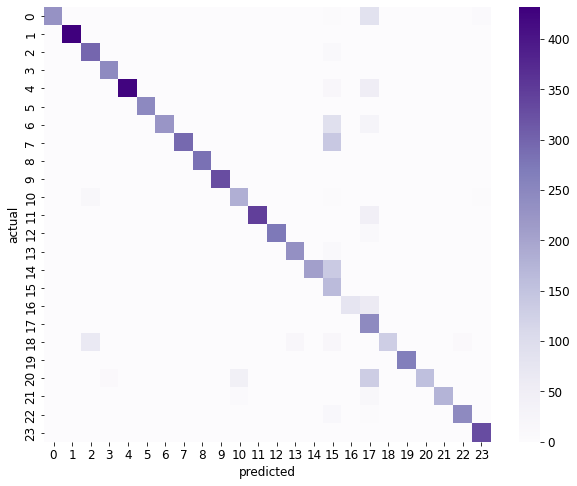

In [228]:
print(f"confusion matrix of he uniform model")
plot_confmat(model_elu_2)

In [229]:
print(f"classification report of he uniform model")
print_report(model_elu_2)

classification report of he uniform model
              precision    recall  f1-score   support

           0       1.00      0.70      0.82       331
           1       1.00      1.00      1.00       432
           2       0.78      0.96      0.86       310
           3       0.96      1.00      0.98       245
           4       1.00      0.86      0.92       498
           5       1.00      1.00      1.00       247
           6       1.00      0.65      0.79       348
           7       1.00      0.68      0.81       436
           8       1.00      0.99      0.99       288
          10       0.99      0.99      0.99       331
          11       0.77      0.88      0.82       209
          12       1.00      0.88      0.94       394
          13       1.00      0.95      0.97       291
          14       0.92      0.95      0.93       246
          15       1.00      0.60      0.75       347
          16       0.26      1.00      0.41       164
          17       1.00      0.55      

use class weight to increase emphasis of correctly predicting on classes with less data

In [235]:
from sklearn.utils import class_weight
w = class_weight.compute_class_weight('balanced', np.unique(y_train.argmax(axis=1)), y_train.argmax(axis=1))

In [236]:
# same architecture but trained with class weights
elu_3 = build_model(keras.activations.elu, keras.initializers.glorot_uniform)
# compile model
elu_3.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.005),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(name='auc')]
)

In [237]:
cb_elu_3 = [keras.callbacks.ModelCheckpoint('model_elu3_base.h5', monitor='val_auc', mode='max',save_best_only=True), 
          keras.callbacks.ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.3, patience=2, min_lr=0.00001)]

In [238]:
history_elu3 = elu_3.fit(generator.flow(X_train, y_train, batch_size=32), \
                    epochs=20, \
                    validation_data=generator.flow(X_val, y_val, batch_size=32), \
                    callbacks=cb_elu_3,
                    verbose=2,
                    class_weight=dict(enumerate([*w[0:9],0,*w[9:]])))

Epoch 1/20
687/687 - 18s - loss: 1.2437 - accuracy: 0.6917 - precision: 0.8014 - recall: 0.6401 - auc: 0.9532 - val_loss: 0.2953 - val_accuracy: 0.9049 - val_precision: 0.9203 - val_recall: 0.8911 - val_auc: 0.9949
Epoch 2/20
687/687 - 16s - loss: 0.1468 - accuracy: 0.9542 - precision: 0.9601 - recall: 0.9495 - auc: 0.9980 - val_loss: 0.2010 - val_accuracy: 0.9472 - val_precision: 0.9519 - val_recall: 0.9445 - val_auc: 0.9949
Epoch 3/20
687/687 - 16s - loss: 0.0731 - accuracy: 0.9778 - precision: 0.9801 - recall: 0.9759 - auc: 0.9989 - val_loss: 0.0805 - val_accuracy: 0.9743 - val_precision: 0.9761 - val_recall: 0.9732 - val_auc: 0.9984
Epoch 4/20
687/687 - 16s - loss: 0.0839 - accuracy: 0.9751 - precision: 0.9768 - recall: 0.9740 - auc: 0.9982 - val_loss: 0.0986 - val_accuracy: 0.9714 - val_precision: 0.9735 - val_recall: 0.9709 - val_auc: 0.9979
Epoch 5/20
687/687 - 16s - loss: 0.0792 - accuracy: 0.9781 - precision: 0.9794 - recall: 0.9775 - auc: 0.9982 - val_loss: 0.0320 - val_accur

learning curve of glorot uniform model with class weight


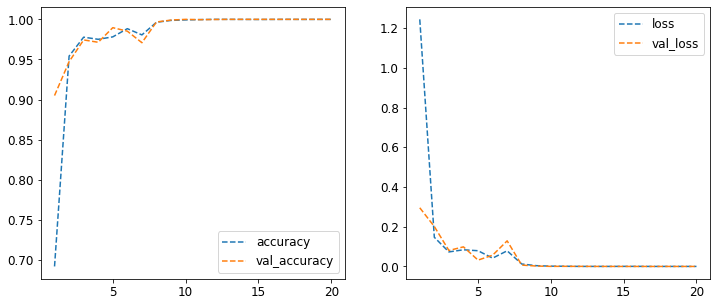

In [239]:
print(f"learning curve of glorot uniform model with class weight")
plot_learning_curve(history_elu3)

using class weight make the model take more time to converge than previous models

225/225 [==============================] - 4s 19ms/step - loss: 0.0151 - accuracy: 0.9961 - precision: 0.9962 - recall: 0.9960 - auc: 0.9996

test loss: 0.01514306478202343
test accuracy: 99.61 %
test precision: 0.9962342977523804
test recall: 0.9959564805030823
test AUC: 0.9995643496513367

Enter image index: 49920
label: 24
actual label: 24


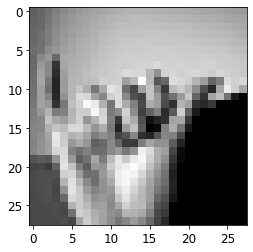

In [240]:
evaluate(elu_3)

confusion matrix of glorot uniform model with class weight


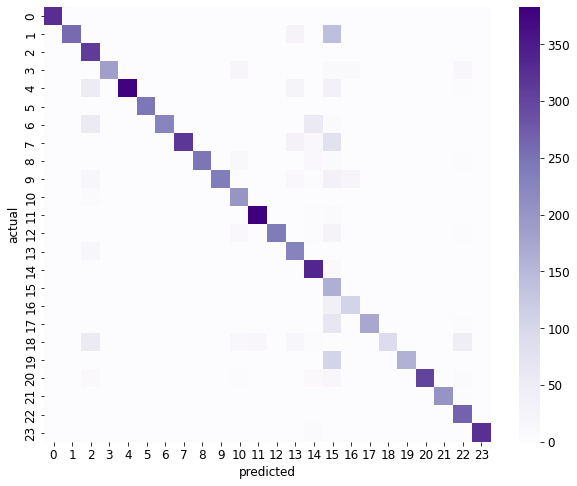

In [241]:
print(f"confusion matrix of glorot uniform model with class weight")
plot_confmat(elu_3)

In [255]:
print(f"classification report of glorot uniform model with class weight")
print_report(elu_3)

classification report of glorot uniform model with class weight
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       331
           1       1.00      0.60      0.75       432
           2       0.58      1.00      0.74       310
           3       1.00      0.76      0.86       245
           4       1.00      0.76      0.87       498
           5       1.00      1.00      1.00       247
           6       1.00      0.65      0.79       348
           7       1.00      0.72      0.84       436
           8       1.00      0.86      0.92       288
          10       1.00      0.72      0.84       331
          11       0.75      0.96      0.84       209
          12       0.96      0.97      0.96       394
          13       1.00      0.82      0.90       291
          14       0.66      0.93      0.77       246
          15       0.74      0.97      0.84       347
          16       0.22      1.00      0.36       164
          17     

In [247]:
def build_dropout_model(func, init, drop_rate=0.4):
    keras.backend.clear_session()
    model = build_model(func, init)
    model.pop()
    model.add(keras.layers.Dense(128, kernel_initializer=init()))
    model.add(keras.layers.Dropout(drop_rate))
    model.add(keras.layers.Dense(y.shape[1], activation='softmax', kernel_initializer=init()))
    return model

In [248]:
# added extra dense layer to prevent underfitting and drop out to prevent overfitting
drop_elu = build_dropout_model(keras.activations.elu, keras.initializers.glorot_uniform)
# compile model
drop_elu.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.005),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(name='auc')]
)

In [249]:
# deine model callback
cb_elu_dropout = [keras.callbacks.ModelCheckpoint('model_dropout_elu.h5', monitor='val_auc', mode='max',save_best_only=True), 
          keras.callbacks.ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.3, patience=2, min_lr=0.00001)]

In [250]:
history_dropout_elu = drop_elu.fit(generator.flow(X_train, y_train, batch_size=32), \
                    epochs=20, \
                    validation_data=generator.flow(X_val,y_val,batch_size=32), \
                    callbacks=cb_elu_dropout,
                    verbose=2)

Epoch 1/20
687/687 - 28s - loss: 2.3127 - accuracy: 0.5642 - precision: 0.6567 - recall: 0.5013 - auc: 0.9095 - val_loss: 0.4422 - val_accuracy: 0.8563 - val_precision: 0.8805 - val_recall: 0.8363 - val_auc: 0.9910
Epoch 2/20
687/687 - 17s - loss: 0.3842 - accuracy: 0.8784 - precision: 0.8938 - recall: 0.8658 - auc: 0.9918 - val_loss: 0.2613 - val_accuracy: 0.9237 - val_precision: 0.9273 - val_recall: 0.9182 - val_auc: 0.9935
Epoch 3/20
687/687 - 17s - loss: 0.2584 - accuracy: 0.9267 - precision: 0.9322 - recall: 0.9234 - auc: 0.9933 - val_loss: 0.1826 - val_accuracy: 0.9503 - val_precision: 0.9530 - val_recall: 0.9492 - val_auc: 0.9956
Epoch 4/20
687/687 - 17s - loss: 0.2901 - accuracy: 0.9330 - precision: 0.9359 - recall: 0.9315 - auc: 0.9903 - val_loss: 0.2803 - val_accuracy: 0.9370 - val_precision: 0.9385 - val_recall: 0.9366 - val_auc: 0.9901
Epoch 5/20
687/687 - 17s - loss: 0.2746 - accuracy: 0.9464 - precision: 0.9479 - recall: 0.9456 - auc: 0.9903 - val_loss: 0.1340 - val_accur

learning curve of glorot uniform model with dropout


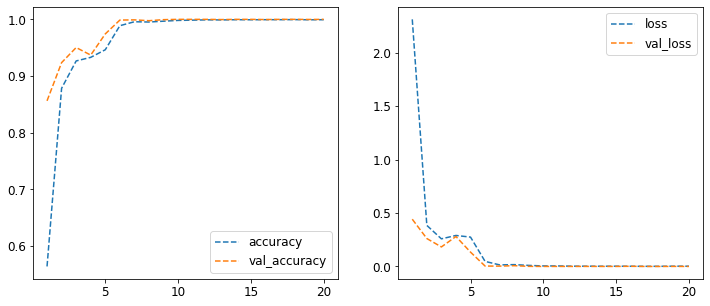

In [251]:
print(f"learning curve of glorot uniform model with dropout")
plot_learning_curve(history_dropout_elu)

model took nearly long as first glorot uniform model to converge

225/225 [==============================] - 5s 20ms/step - loss: 0.0167 - accuracy: 0.9961 - precision: 0.9962 - recall: 0.9961 - auc: 0.9995

test loss: 0.016699105501174927
test accuracy: 99.61 %
test precision: 0.9962348341941833
test recall: 0.9960959553718567
test AUC: 0.9995009303092957

Enter image index: 995
label: 5
actual label: 5


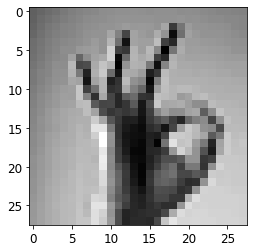

In [260]:
evaluate(drop_elu)

confusion matrix of glorot uniform model with dropout


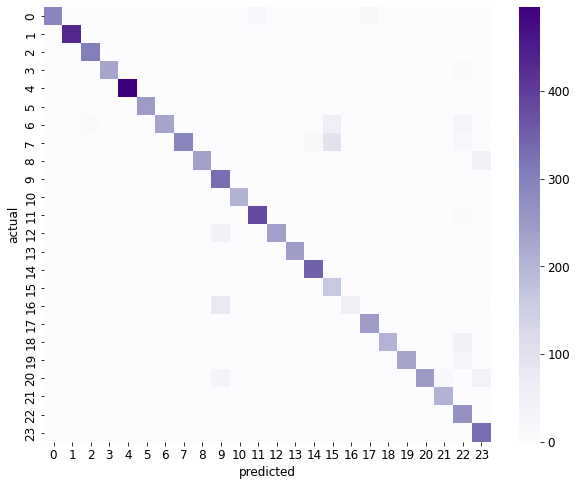

In [253]:
print(f"confusion matrix of glorot uniform model with dropout")
plot_confmat(drop_elu)

In [254]:
print(f"classification report of glorot uniform model with dropout")
print_report(drop_elu)

classification report of glorot uniform model with dropout
              precision    recall  f1-score   support

           0       1.00      0.88      0.93       331
           1       0.99      1.00      1.00       432
           2       0.97      0.99      0.98       310
           3       1.00      0.94      0.97       245
           4       1.00      1.00      1.00       498
           5       1.00      1.00      1.00       247
           6       1.00      0.66      0.80       348
           7       1.00      0.67      0.80       436
           8       1.00      0.83      0.91       288
          10       0.67      1.00      0.80       331
          11       1.00      0.99      1.00       209
          12       0.95      0.98      0.96       394
          13       1.00      0.82      0.90       291
          14       0.98      1.00      0.99       246
          15       0.93      1.00      0.96       347
          16       0.50      1.00      0.66       164
          17       1.0